# Predictions Analysis - FNN V14
Checks predicted from pytorch model

In [1]:
import torch
import re

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, confusion_matrix, f1_score, log_loss

In [2]:
# Directory to the repository
repo_dir = '/Users/johnjoba/local_git_repos/sts_cockpit'

In [3]:
# Load in the master card list and master relic list
f = open(f'{repo_dir}/data/master_lists/master_card_list.txt', 'r')
master_card_list = f.readlines()
f.close()

# Pull in the master card list to ensure each file has the same schema
f = open(f'{repo_dir}/data/master_lists/master_relic_list.txt', 'r')
master_relic_list = f.readlines()
f.close()

# Process lists into dictionaries with value 1 to ensure all items are captured
master_card_list = [re.sub('\n', '', card) for card in master_card_list]
master_relic_list = [re.sub('\n', '', relic) for relic in master_relic_list]

# List of card & relic name changes to current game
recodes = {
    'underhanded_strike':'sneaky_strike', 
    'underhanded_strike_u':'sneaky_strike_u',
    'wireheading':'foresight', 
    'wireheading_u':'foresight_u', 
    'conserve_battery':'charge_battery',
    'conserve_battery':'charge_battery_u', 
    'lockon':'bullseye',
    'lockon_u':'bullseye_u',
    'undo':'equilibrium',
    'undo_u':'equilibrium_u',
    'steam_power': 'steam_barrier',
    'steam_power_u':'steam_barrier_u',
    'molten_egg_2': 'molten_egg',
    'toxic_egg_2': 'toxic_egg',
    'frozen_egg_2': 'frozen_egg'
  }

# Recode the card and relic lists
master_card_list = [recodes[k] if k in recodes.keys() else k for k in master_card_list]
master_relic_list = [recodes[k] if k in recodes.keys() else k for k in master_relic_list]

In [4]:
# Setup device for loading model
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [5]:
# NOTE: directory is hardcoded!!
model_version = 'fnn_v14'

# Load model
model = torch.jit.load(f'{repo_dir}/model_objects/production/{model_version}.pth').to(device)
model.eval()


RecursiveScriptModule(
  original_name=NeuralNetwork
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (linear_relu_stack): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Dropout)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=Dropout)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Dropout)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=Sigmoid)
  )
)

In [6]:
# Load data
test_data = pd.read_csv(f'{repo_dir}/data/training_data/finetuning/test/test.csv')

In [7]:
# gets the predicted values
with torch.no_grad():
    x = torch.from_numpy(test_data.drop('victory', axis = 1).to_numpy().astype(np.float32)).to(device)
    pred = model(x)
 
 # Load predictions into the test data set for comparison
test_data['probs'] = pred.cpu().numpy()
test_data['preds'] = np.int32(test_data['probs'] > 0.5)

In [8]:
# Calculate accuracy
print(f'Accuracy: {((sum(test_data['preds'] == test_data['victory']) / test_data.shape[0]) * 100):>0.2f}%')

Accuracy: 98.01%


In [9]:
# Run confusion matrix
# 0,0 = TN, 1,0 = FN, 1,1 = TP, 0,1 = FP
confusion_matrix(test_data['victory'], test_data['preds'], normalize='true')

# Recall is ~65%, meaning we identify ~2/3s of winning runs

array([[0.99355204, 0.00644796],
       [0.3459377 , 0.6540623 ]])

In [10]:
# F1 Score (higher is better)
f1_score(test_data['victory'], test_data['preds'])

0.722763167982826

In [11]:
# Log Loss (lower is better, should match test loss from train_model.py)
log_loss(test_data['victory'], test_data['probs'])

0.043761398623200845

In [12]:
# Calculates Brier Score (lower is better) to assess predicted probability calibration
print(f'Brier Score: {(brier_score_loss(test_data['victory'], test_data['probs'])):>0.4f}')

Brier Score: 0.0140


In [13]:
# Take a look through the top & bottom few decks to see what the model is thinking
for asc in [True, False]:
    print(f'Ascensing Order: {asc}')
    sorted = test_data.sort_values(by = ['probs'], ascending = True).copy()

    top_n = 5

    for i in range(top_n):
        temp = {k:v for k, v in sorted.iloc[i].to_dict().items() if v != 0}

        print(temp)

        print('-' * 15)

Ascensing Order: True
{'a_thousand_cuts': 2.0, 'adrenaline': 1.0, 'all_out_attack_u': 1.0, 'ascendersbane': 1.0, 'bane': 1.0, 'bouncing_flask': 1.0, 'catalyst': 1.0, 'choke': 2.0, 'concentrate': 1.0, 'crippling_poison': 1.0, 'dagger_spray': 1.0, 'deadly_poison': 1.0, 'deflect': 1.0, 'endless_agony': 1.0, 'expertise': 1.0, 'finisher': 1.0, 'flechettes': 1.0, 'flying_knee': 3.0, 'glass_knife': 1.0, 'heel_hook': 2.0, 'injury': 1.0, 'malaise': 1.0, 'neutralize': 1.0, 'noxious_fumes': 2.0, 'reflex': 1.0, 'regret': 1.0, 'survivor': 1.0, 'tactician': 1.0, 'venomology_u': 1.0, 'writhe': 1.0, 'akabeko': 1.0, 'ancient_tea_set': 1.0, 'golden_idol': 1.0, 'mawbank': 1.0, 'mealticket': 1.0, "nloth's_gift": 1.0, 'orichalcum': 1.0, "pandora's_box": 1.0, 'regal_pillow': 1.0, 'stonecalendar': 1.0, 'toxic_egg': 1.0, 'the_silent': 1.0, 'probs': 5.6191943459404925e-12}
---------------
{'accuracy': 1.0, 'acrobatics': 1.0, 'adrenaline_u': 1.0, 'after_image': 1.0, 'all_out_attack': 1.0, 'ascendersbane': 1.0, 

In [14]:
# Convenience fields for plotting later on
test_data['deck_size'] = test_data[master_card_list].sum(axis = 1)
test_data['character'] = 'unknown'
test_data.iloc[test_data['ironclad'] == 1, 867] = 'ironclad'
test_data.iloc[test_data['the_silent'] == 1, 867] = 'the_silent'
test_data.iloc[test_data['defect'] == 1, 867] = 'defect'
test_data.iloc[test_data['watcher'] == 1, 867] = 'watcher'


# Defect, Ironclad, The Silent, Watcher
sts_colors = ['#4CC9EC', '#E65252', '#A1AC4C', '#C389FF']

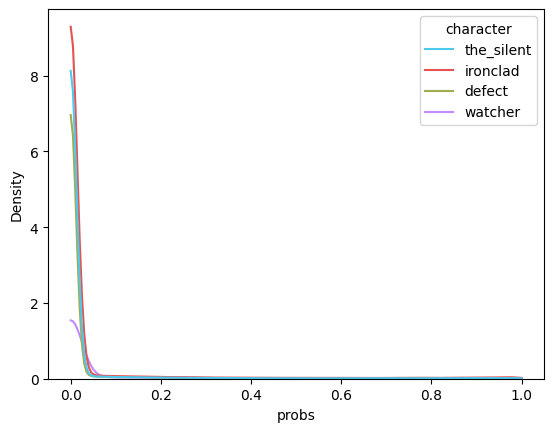

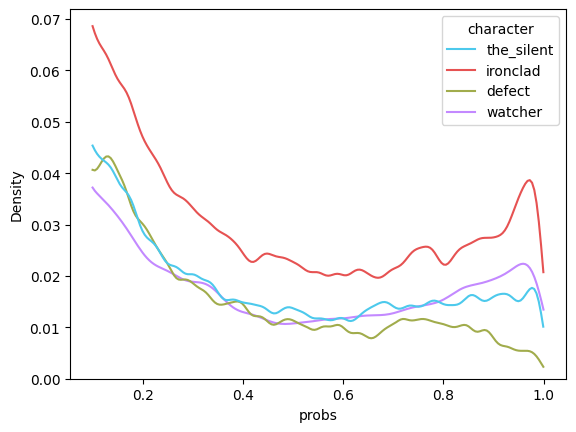

In [15]:
# Distribution of Predicted Win Rates
sns.kdeplot(test_data, x = 'probs', hue = 'character', palette = sts_colors, cut = 0, clip = [0, 1])
plt.show()

# With all the mass at 0, zooming in to look past 0.1 to see if there's any lift in prediected rate
sns.kdeplot(test_data, x = 'probs', hue = 'character', palette = sts_colors, cut = 0, clip = [0.1, 1])
plt.show()

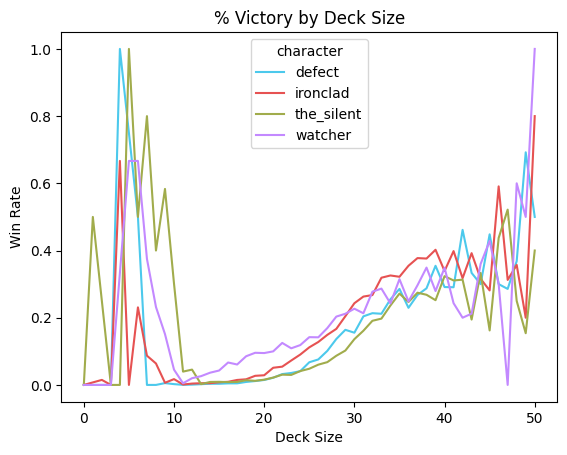

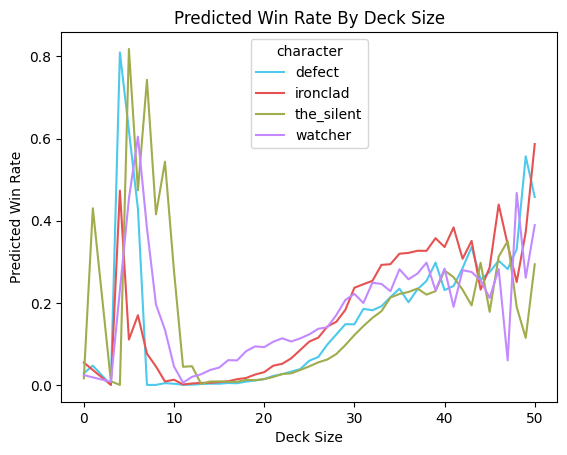

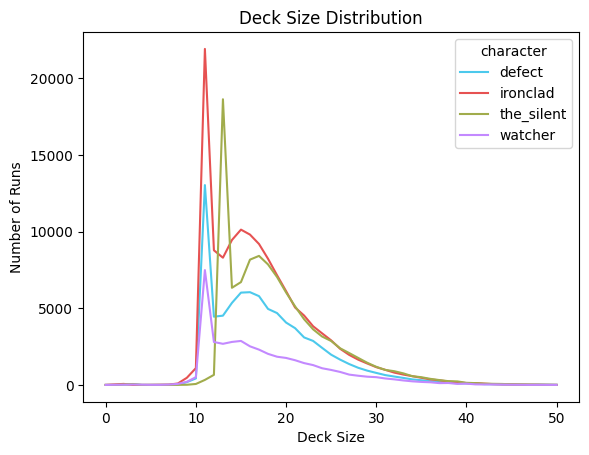

In [16]:
# It generally seems that more cards in the deck leads to a lower win rate. Winning decks seem to have fewer cards and a lot of relics
plot_df = test_data[test_data['deck_size'] <= 50][['deck_size', 'victory', 'character']].groupby(['character', 'deck_size']).mean()

sns.lineplot(data = plot_df, x = 'deck_size', y = 'victory', hue = 'character', palette = sts_colors).set_title('% Victory by Deck Size')
plt.ylabel('Win Rate')
plt.xlabel('Deck Size')
plt.show()

plot_df = test_data[test_data['deck_size'] <= 50][['deck_size', 'probs', 'character']].groupby(['character', 'deck_size']).mean()
sns.lineplot(data = plot_df, x = 'deck_size', y = 'probs', hue = 'character', palette = sts_colors).set_title('Predicted Win Rate By Deck Size')
plt.ylabel('Predicted Win Rate')
plt.xlabel('Deck Size')
plt.show()

plot_df = test_data[test_data['deck_size'] <= 50][['deck_size', 'victory', 'character']].groupby(['character', 'deck_size']).count()
sns.lineplot(data = plot_df, x = 'deck_size', y = 'victory', hue = 'character', palette = sts_colors).set_title('Deck Size Distribution')
plt.ylabel('Number of Runs')
plt.xlabel('Deck Size')
plt.show()